In [1]:
from nameparser import HumanName
import pandas
import numpy
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

### Read the data

In [2]:
data = pandas.read_csv('gr-qc.tsv.xz', compression='xz', sep='\t')

/home/ecm/arxiv-processing/arxiv_proc/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns

Index(['Unnamed: 0', 'abstract', 'acm_class', 'arxiv_id', 'author_text',
       'categories', 'comments', 'created', 'doi', 'num_authors',
       'num_categories', 'primary_cat', 'title', 'updated', 'categories_list'],
      dtype='object')

### Filter gravitational wave-related papers and exclude long-author-list collaboration papers

In [4]:
#searchfor = ['gravitational', 'wave']
searchfor = ['gravitational wave']
papers = data[((data['title'].str.contains('|'.join(searchfor))) | \
                  (data['abstract'].str.contains('|'.join(searchfor)))) & \
                  (data['created'].between('2014-01-01','2019-01-01')) & \
                  (data['num_authors'] < 50) & \
                  (data['num_authors'] > 1)]
print("selected {} articles".format(len(papers)))

selected 1818 articles


### Extract and parse author names

In [48]:
names = map(str.strip,','.join(papers['author_text']).split(','))
names = list(set(names)) # remove duplicates
formatted_names = [HumanName(n) for n in names]
print("there are {} authors".format(len(formatted_names)))

there are 3910 authors


### Produce a final, cleaned list of the authors' last names 

In [53]:
tag_names = ['-'.join((n.first[0],n.last)) if n.first \
              else '-'.join(('XX',n.last)) \
              for n in formatted_names]
tag_names = list(set(tag_names))  # remove duplicates
IMPROPER_NAMES = ('Collaboration', 'collaboration')
for t in tag_names: # ad-hoc fix for this type of entry
    if any([n in t for n in IMPROPER_NAMES]):
        tag_names.remove(t)
print("there are {} authors in the cleaned list".format(len(last_names)))

there are 2860 authors in the cleaned list


### Create authors' graph

In [55]:
collaborators = nx.Graph()
collaborators.add_nodes_from(tag_names, weight=0)

### Create edges in graph for co-authors

In [61]:
for index, p in papers.iterrows():
    byline = [HumanName(n) for n in p['author_text'].split(',')]
    authors = ['-'.join((n.first[0],n.last)) if n.first \
                      else '-'.join(('XX',n.last)) \
                      for n in byline]
    for author in authors:
        if author not in tag_names:
            continue
        collaborators.nodes[author]['weight'] += 1
    for pair in itertools.combinations(authors, 2):
        if any(a not in tag_names for a in pair):
            continue
        if pair[0] == pair[1]:
            print("Found duplicate in {}!: {} = {}".format(p['arxiv_id'],pair[0],pair[1]))
            continue
        if collaborators.has_edge(*pair):
            collaborators.edges[pair[0],pair[1]]['weight'] += 1
        else:
            collaborators.add_edge(*pair, weight=1)

Found duplicate in 1503.08751!: A-Stabile = A-Stabile
Found duplicate in 1512.02076!: Y-Wang = Y-Wang
Found duplicate in 1601.02357!: S-Banerjee = S-Banerjee
Found duplicate in 1602.07198!: S-Chakraborty = S-Chakraborty
Found duplicate in 1602.08514!: S-Chakraborty = S-Chakraborty
Found duplicate in 1702.08187!: W-Ni = W-Ni
Found duplicate in 1704.06784!: A-Ghosh = A-Ghosh
Found duplicate in 1711.0773!: Q-Wang = Q-Wang
Found duplicate in 1804.08379!: X-Zhang = X-Zhang


In [62]:
print('The collab graph has {} nodes and {} edges'.format(collaborators.number_of_nodes(), \
                                                          collaborators.number_of_edges()))
#print(collaborators.nodes, collaborators.edges)

The collab graph has 3285 nodes and 19053 edges


### Quick view

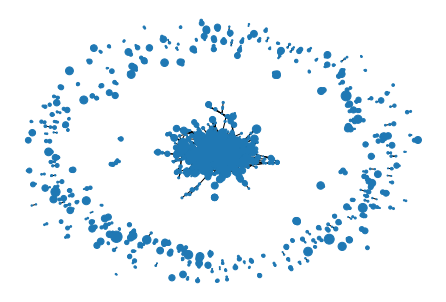

In [63]:
d = dict(collaborators.degree)
nx.draw(collaborators, labelsnodelist=d.keys(), node_size=[v for v in d.values()])

Text(0.5, 0, 'Degree')

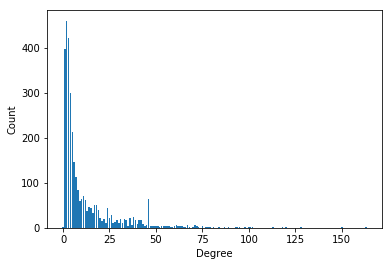

In [64]:
degree_sequence = sorted([d for n, d in collaborators.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt)
plt.ylabel("Count")
plt.xlabel("Degree")

### Export graph to GML file

In [65]:
 nx.write_gml(collaborators, "gw-arxiv.gml")